# Introduction to Regression Methods

This post will be a walkthrough on fitting, feature selection, making inferences and evaluating assumptions using multiple regression in the context of predicting housing prices using a dataset provided by Kaggle.

## Model Assumptions

First and foremost, we begin with the assumptions of linear regression models.

 -The datapoints should be independent from one another.
 -The independent variables (i.e. features of our data) should not be extremely correlated
 -The relationship between the mean of our dependent variable conditioned on a particular set of independent feature
  values is linear. I.e. if <b>x</b> is our feature vector, then the dependent variable y should be expressable as a
  dot product between <b>x</b> and our coefficient vector.
 -(Optional for inference) The variance of y should be independent of our <b>x</b> values. If this assumption is
  violated, then the model coefficients we have estimated will have underestimated standard errors, thus making our
  inferences about the significance of those coefficients unreliable. The confidence intervals we generate for each
  prediction will also be too "narrow". However, if the goal is purely deterministic prediction, then this assumption
  need not hold.

## Exploring the data

Exploring our data will allow us to get an idea of how it is distributed, which features may be informative and will prepare us for adding value to our models through the use of heuristics.

Before we can start exploring the data though, it helps to do some preliminary cleaning. In the case of this dataset, this means filling in missing values. There are many ways to do this and really stem from where and how the data is being generated. For continuous features which are usually obtained through measurements, we may interpret missing data as unavailability and not indicative of any special categorization or characteristics of the datapoint; in this case, we may fill it in with the mean of the feature. For numerical features that are discrete and perhaps indicate a count of something or a categorization, a missing value may make more sense as 0 or a category of "Missing". Other fill in methods include using the median, mode, discarding the feature and training a separate model to predict the missing feature value.

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('data/kaggle_housing_train.csv')

#move house prices to a separate vector and log them to get them normally distributed
prices = df_train['SalePrice']
log_prices = np.log(prices)
df_train = df_train.drop('SalePrice', axis=1)

df_test = pd.read_csv('data/kaggle_housing_test.csv')

#concatenate training and test data for now so we don't have to do processing twice everytime
all_data = pd.concat((df_train, df_test))


#look at the features with missing values
print("{} datapoints".format(len(all_data)))

#break up for categorical and numerical features for processing
all_num = all_data.select_dtypes(exclude=['object'])
all_cat = all_data.select_dtypes(include=['object'])

missing_feats = np.sum(all_data.isnull(), axis=0)
missing_featnames = all_data.columns[missing_feats != 0]
missing_num_feats = all_num.columns[all_num.columns.isin(missing_featnames)]
missing_cat_feats = all_cat.columns[all_cat.columns.isin(missing_featnames)]

missing_feats[missing_feats > 0]

2919 datapoints


MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [31]:
#There are some numericals that are continuous and others discrete/categorical encodings
#We can be pretty sure which are which when we look at the unique counts
all_data.loc[:,missing_num_feats].apply(lambda x: len(x.unique()))

LotFrontage      129
MasVnrArea       445
BsmtFinSF1       992
BsmtFinSF2       273
BsmtUnfSF       1136
TotalBsmtSF     1059
BsmtFullBath       5
BsmtHalfBath       4
GarageYrBlt      104
GarageCars         7
GarageArea       604
dtype: int64

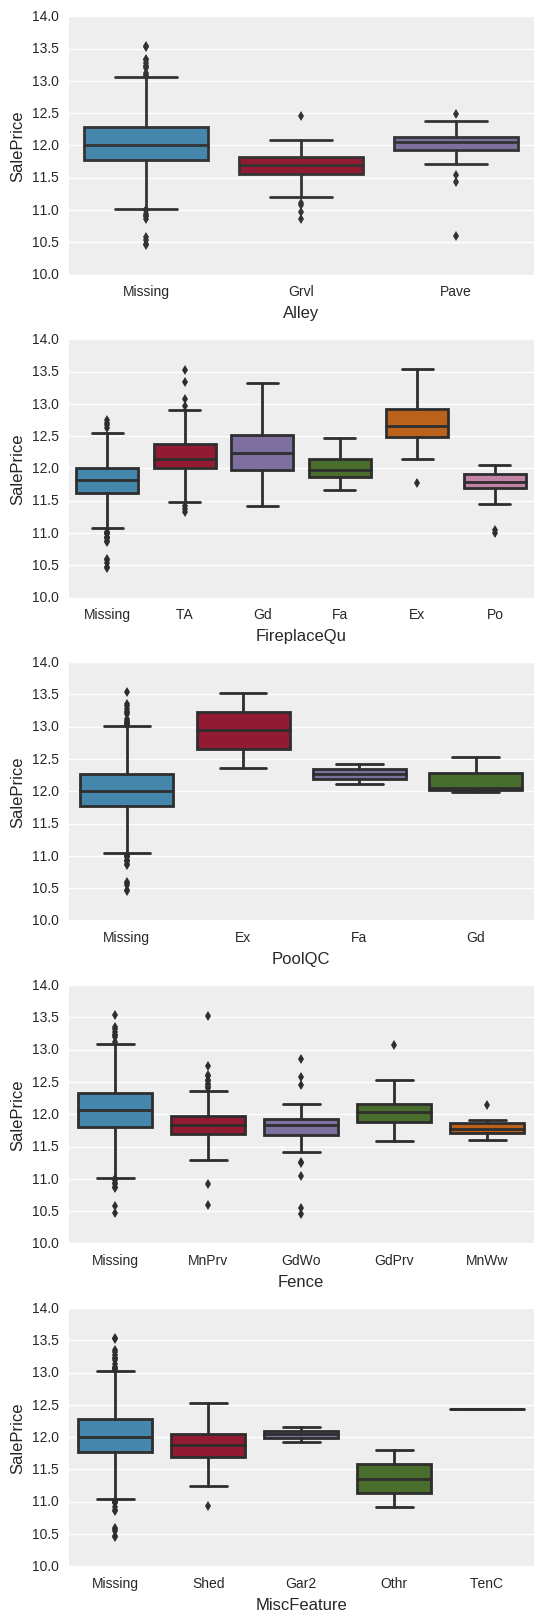

In [4]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.style.use('bmh')

#plot features with a lot of missing values to see if they have any value
#if not we should just drop them
excessive_missing = all_data.columns[missing_feats > 1400]
fig, axes = plt.subplots(nrows=len(excessive_missing), ncols=1, figsize=(6, len(excessive_missing)*4))
for ax, f in zip(axes, excessive_missing):
    if len(all_data[f].unique()) > 10:
        plt.scatter(df_train[f].fillna(0), log_prices, color='g', ax=ax)
    else:
        sns.boxplot(df_train[f].fillna('Missing'), log_prices, ax=ax)
plt.subplots_adjust(hspace=.25)

It seems there's some difference in sales price for properties with missing values vs. those without. There are more formal ways to test this, e.g. with ANOVA. But for our demonstrative purposes, boxplotting them should be enough. We fill in the missing values next.

In [5]:
#For continuous, fill missing values with mean
#For discrete numericals, they seem to be count data, so we can fill these in with 0
all_data.loc[:, missing_num_feats] = all_data.loc[:, missing_num_feats].apply(lambda x: x.fillna(x.mean()) 
                                                                                      if len(x.unique()) > 100 
                                                                                      else x.fillna(0))
#For categoricals, add a "missing" value to the columns which will be dummified later as an extra category
all_data.loc[:, missing_cat_feats] = all_data.loc[:, missing_cat_feats].apply(lambda x: x.fillna('Missing'))

## Looking at Time Series Data

This data does have transaction month and year of sale values. Before we begin exploring other features and fitting our model, it is important to make sure our data is not "autocorrelated" (i.e. points are independent of past points). If this is not the case, then we have to "stationarize" our data.

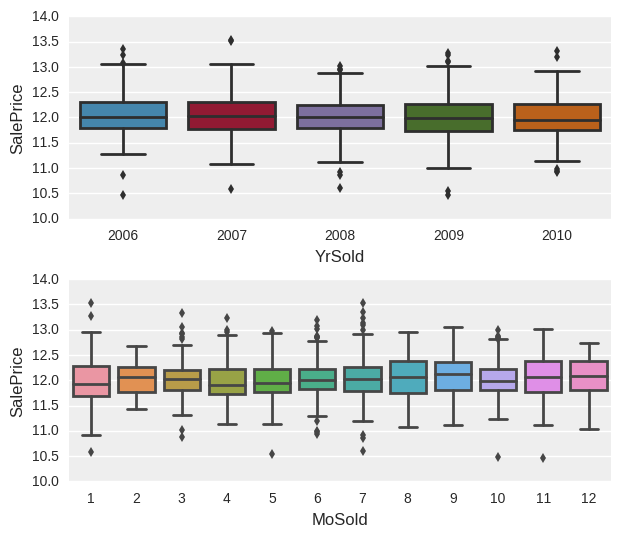

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 2*3))
sns.boxplot(df_train['YrSold'], log_prices, ax=axes[0])
sns.boxplot(df_train['MoSold'], log_prices, ax=axes[1])
plt.subplots_adjust(hspace=.3)

Whew, there doesn't seem to be any major trends, correlations or seasonalities between sales over time. Since the real estate market is not as transparent and liquid as other assets such as equities, commodities and bonds, it makes sense that sales at one point in time do not siginificantly influence sales later. If our data was more concentrated in one region with significant development, then we probably would have seen more of a trend. 

## Normalizing our Data

It also helps to first normalize our independent variables. This is not a necessary assumption for linear regression; however, if our data is highly skewed, we want to transform it in such a way that a unit increase of 10 from 100 to 110 has the same effect on the dependent variable as an increase from 10000 to 10010.

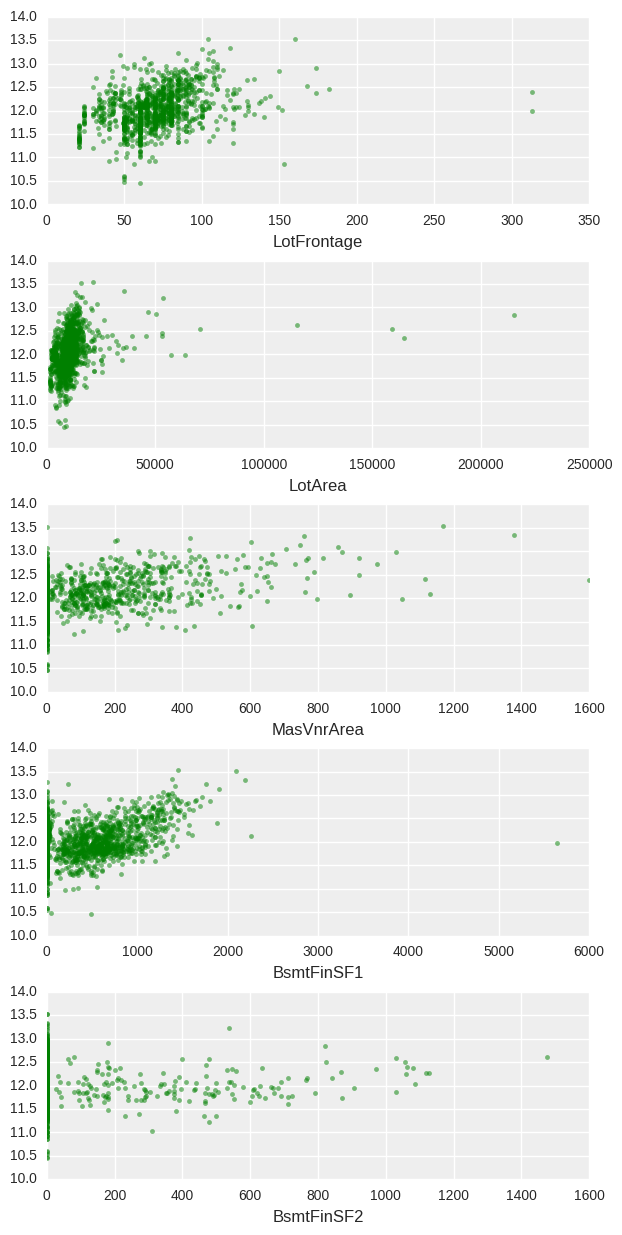

In [17]:
from scipy.stats import skew

#Variables with more than 100 unique values are likely continuous
continuous_feats = [f for f in all_data.columns if len(all_data[f].unique()) > 100]
discrete_feats = [f for f in all_data.columns if len(all_data[f].unique()) <= 100]

#For continuous features, log(1+x) transform the feature if the skew is big enough
skewed_feats = [f for f in continuous_feats if skew(all_data[f]) > .75]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(7, 15))

for i, f in enumerate(skewed_feats[:5]):
    axes[i].plot(df_train[f], log_prices, '.', color='g', alpha=.5)
    axes[i].set_xlabel(f)
plt.subplots_adjust(hspace=.3)

In [18]:
#Notice that for these features, the change in log of sale price as the feature value increases become less pronounced
#This is non-linear in behavior and calls for a log(1+x) transformation

all_data.loc[:, skewed_feats] = all_data.loc[:, skewed_feats].apply(lambda x: np.log1p(x))

## Gold at the End of the Rainbow

Feature engineering and, on a lesser scale, feature selection are both art as much as science. If we think of machine learning as attempting to approximate some function over an extremely large set of dimensions, the part where we humans can still contribute some value is in providing some structure to make the function search easier.

There are a number of heuristics and statistics that can be used to quantify the predictive value of our features. We can use ANOVA to test the statistical significance of a categorical variable's relationship with the dependent mean. Other measures of dependence between two variables include correlation and mutual information score. As usual, visualizations can also help.

Since our dependent variable is continuous, it makes sense to use correlation and ANOVA.

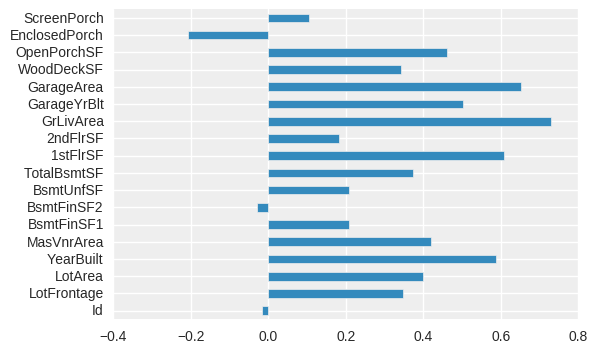

In [20]:
from scipy.stats import f_oneway, pearsonr

#reset the train and test dataframes to views of all_data since we did our preprocessing on all_data only
df_train = all_data[:len(df_train)]
df_test = all_data[len(df_train):]

#calculate pearson's correlation for continuous features and anova p-values for discrete features
feat_corrs = df_train.loc[:, continuous_feats].apply(lambda x: pearsonr(x, log_prices)[0])
feat_corrs.plot(kind='barh')

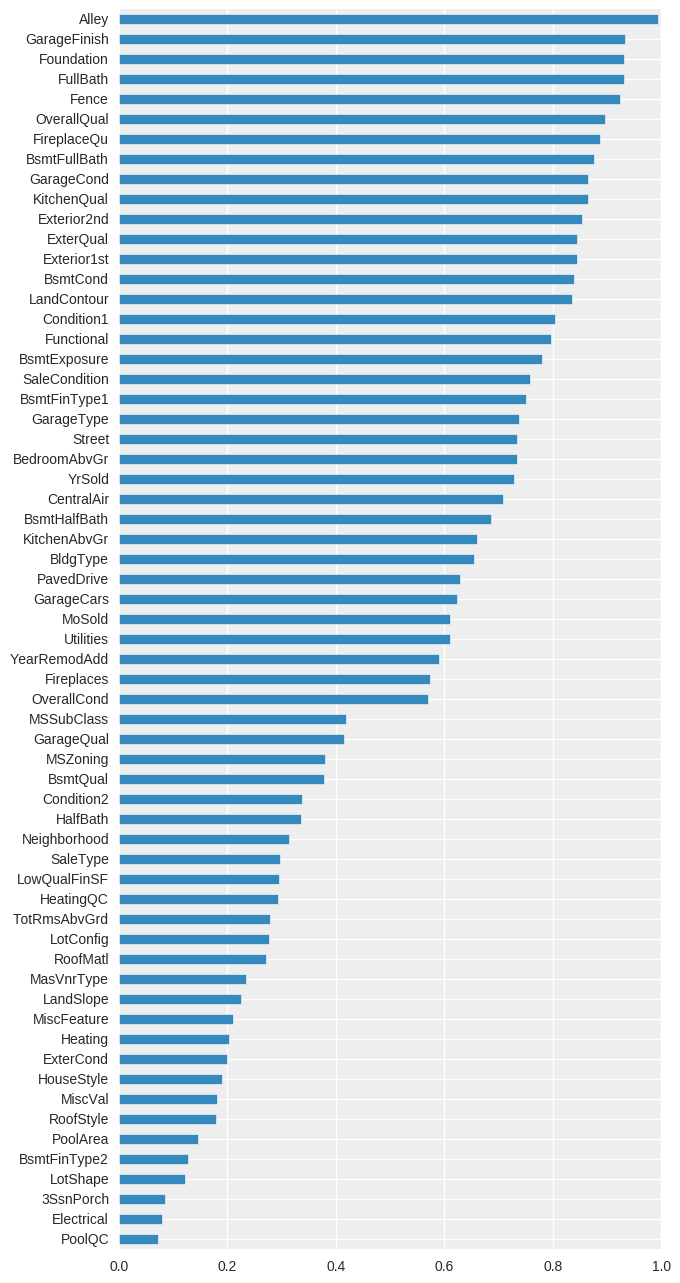

In [37]:
def anova(f_name):
    #concatenate the prices and feature and then group them and extract the grouped prices as a list of lists
    grouped_prices = pd.concat((df_train[f_name], log_prices), axis=1).groupby(f_name).groups.values()
    #split the list of lists of prices and pass into scipy's one way anova function which returns a F-statistic and p-value
    return f_oneway(*grouped_prices)[1]

feat_anova_pvalues = pd.Series({f: anova(f) for f in discrete_feats}).sort_values()
#lower pvalues means more statistical significance so we plot 1-pvalues 
feat_anova_pvalues.plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches((7, 16))